In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy.signal import savgol_filter
import seaborn as sns
import ast
sns.set()

# Trajectories (obs, actions, penalty)

In [2]:
!ls ../data/a3c

a3c_trajectories_0.csv	a3c_trajectories_1.csv	a3c_trajectories_2.csv


In [47]:
#path = "../results/vanilla_a3c_v2_lite_env_6_UE_100_GPUperEDC_10_consistent_APs_standarize_data_and_Qvalues_rewardFunc_sumPOto3P1to3P2to3_adam_1e3_ep_240_penalty_0/"
path = "../data/"
df = pd.read_csv(path+'a3c/a3c_trajectories_1.csv',
                 delimiter=";",
                 names = ["util_0", "power_0",
                          "util_1", "power_1",
                          "util_2", "power_2",
                          "action", "penalty"]
                )
df

,util_0,power_0,util_1,power_1,util_2,power_2,action,penalty
0,-2.949946,-3.785157,-2.949946,-3.785157,-2.949946,-3.785157,edc_2,False
1,-2.949946,-3.785157,-2.949946,-3.785157,-2.949946,-3.785157,edc_2,False
2,-2.949946,-3.239375,-2.949946,-3.239375,-2.949946,-3.239375,edc_2,False
3,-2.949946,-3.239375,-2.949946,-3.239375,-2.725288,-3.218750,edc_2,False
4,-2.949946,-3.239375,-2.949946,-3.239375,-2.500629,-3.185150,edc_2,False
...,...,...,...,...,...,...,...,...
2265,-2.949946,-3.239375,-1.938983,-2.043959,1.318566,1.311957,edc_2,False
2266,-2.949946,-3.239375,-1.938983,-2.043959,1.430895,1.366661,edc_2,False
2267,-2.949946,-3.239375,-1.938983,-2.043959,1.430895,1.366661,edc_2,False
2268,-2.949946,-3.239375,-2.051312,-2.064480,1.318566,1.337173,edc_2,False


In [48]:
df.action.value_counts()

edc_2    2219
edc_1      38
edc_0      13
Name: action, dtype: int64

In [49]:
df.penalty.value_counts()

False    1775
True      495
Name: penalty, dtype: int64

In [50]:
interval = 100
for i in range(len(df)//interval):
    print(df.iloc[i*interval:(i+1)*interval]["action"].value_counts())

edc_2    94
edc_1     5
edc_0     1
Name: action, dtype: int64
edc_2    98
edc_1     2
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    97
edc_1     2
edc_0     1
Name: action, dtype: int64
edc_2    99
edc_0     1
Name: action, dtype: int64
edc_2    94
edc_1     5
edc_0     1
Name: action, dtype: int64
edc_2    100
Name: action, dtype: int64
edc_2    98
edc_1     1
edc_0     1
Name: action, dtype: int64
edc_2    95
edc_0     3
edc_1     2
Name: action, dtype: int64
edc_2    99
edc_1     1
Name: action, dtype: int64
edc_2    98
edc_1     1
edc_0     1
Name: action, dtype: int64
edc_2    97
edc_1     3
Name: action, dtype: int64
edc_2    98
edc_1     2
Name: action, dtype: int64
edc_2    95
edc_1     4
edc_0     1
Name: action, dtype: int64
edc_2    98
edc_1     1
edc_0     1
Name: action, dtype: int64
edc_2    100
Name: action, dtype: int64
edc_2    97
edc_1     3
Name: action, dtype: int64
edc_2   

In [51]:
gpus_per_edc = 10
scale_dict = {"normalization": {gpus_per_edc: {"power": (58*gpus_per_edc, 80*gpus_per_edc),
                                                        "util": (0, 100*gpus_per_edc),
                                                        "dist": (299.58, 2186.21)
                                                        },
                                        },
               "standarization": {5: {"power": (361.19, 25.89),
                                      "util": (268.08, 111.47),
                                      "dist": (1088.39, 540.25)
                                      },
                                  10: {"power": (944.16, 183.39),
                                       "util": (656.54, 222.56),
                                       "dist": (1088.39, 540.25)
                                       },
                                 }
                      }
scale_mode = "standarization"
scale_factor = gpus_per_edc


def inverse_scale_data(scale_data):
        if scale_mode == "normalization":
            return scale_data * (scale_pair[1] - scale_pair[0]) + scale_pair[0]
        if scale_mode == "standarization":
            return scale_data * scale_pair[1] + scale_pair[0]
        return scale_data
        
scaled_col = ["util_0", "power_0", 
              "util_1", "power_1", 
              "util_2", "power_2"]

scaled_df = df.copy()
scale_pair = scale_dict[scale_mode][scale_factor]["util"]
scaled_df[scaled_col[0::2]] = scaled_df[scaled_col[0::2]].apply(inverse_scale_data)

scale_pair = scale_dict[scale_mode][scale_factor]["power"]
scaled_df[scaled_col[1::2]] = scaled_df[scaled_col[1::2]].apply(inverse_scale_data)

scaled_df["rew_0"] = -(scaled_df["power_0"] / (scaled_df["util_0"]+1))**1
scaled_df["rew_1"] = -(scaled_df["power_1"] / (scaled_df["util_1"]+1))**1
scaled_df["rew_2"] = -(scaled_df["power_2"] / (scaled_df["util_2"]+1))**1
scaled_df["rew"] = scaled_df["rew_0"] + scaled_df["rew_1"] + scaled_df["rew_2"]

In [52]:
scaled_df.describe()

,util_0,power_0,util_1,power_1,util_2,power_2,rew_0,rew_1,rew_2,rew
count,2.270000e+03,2270.000000,2.270000e+03,2270.000000,2.270000e+03,2270.000000,2270.000000,2270.000000,2270.000000,2270.000000
mean,1.574890e+00,352.750330,1.912445e+02,537.132476,8.829185e+02,1165.674034,-329.115516,-11.906495,-1.728544,-342.750555
std,6.075214e+00,11.211161,5.650836e+01,54.001455,1.334044e+02,56.324352,81.573960,58.048383,10.395109,103.187961
min,3.516609e-07,250.000000,3.516609e-07,250.000000,3.516609e-07,250.000000,-392.003665,-520.479675,-350.090935,-1050.272806
25%,3.516609e-07,350.091058,1.750000e+02,493.164985,8.500000e+02,1155.002976,-350.090935,-3.185176,-1.367154,-354.497149
50%,3.516609e-07,350.091058,2.000000e+02,565.554982,9.250000e+02,1179.397274,-350.090935,-2.531537,-1.273647,-354.016801
75%,3.516609e-07,350.091058,2.250000e+02,569.318337,9.750000e+02,1194.792020,-350.090935,-2.519108,-1.224172,-353.809069
max,2.500000e+01,395.704196,3.000000e+02,586.749870,1.000000e+03,1200.225269,-13.533700,-1.852695,-1.183435,-17.999393


In [53]:
scaled_df.head(10)

,util_0,power_0,util_1,power_1,util_2,power_2,action,penalty,rew_0,rew_1,rew_2,rew
0,3.516609e-07,250.000000,3.516609e-07,250.000000,3.516609e-07,250.000000,edc_2,False,-249.999913,-249.999913,-249.999913,-749.999738
1,3.516609e-07,250.000000,3.516609e-07,250.000000,3.516609e-07,250.000000,edc_2,False,-249.999913,-249.999913,-249.999913,-749.999738
2,3.516609e-07,350.091058,3.516609e-07,350.091058,3.516609e-07,350.091058,edc_2,False,-350.090935,-350.090935,-350.090935,-1050.272806
3,3.516609e-07,350.091058,3.516609e-07,350.091058,5.000000e+01,353.873383,edc_2,False,-350.090935,-350.090935,-6.938694,-707.120564
4,3.516609e-07,350.091058,3.516609e-07,350.091058,1.000000e+02,360.035280,edc_2,False,-350.090935,-350.090935,-3.564706,-703.746576
5,3.516609e-07,350.091058,3.516609e-07,350.091058,1.000000e+02,937.247786,edc_2,False,-350.090935,-350.090935,-9.279681,-709.461552
6,3.516609e-07,350.091058,3.516609e-07,350.091058,1.500000e+02,954.043918,edc_2,False,-350.090935,-350.090935,-6.318172,-706.500042
7,3.516609e-07,350.091058,3.516609e-07,350.091058,3.500000e+02,1003.232290,edc_2,False,-350.090935,-350.090935,-2.858212,-703.040082
8,3.516609e-07,350.091058,3.516609e-07,350.091058,4.000000e+02,1012.795400,edc_2,False,-350.090935,-350.090935,-2.525674,-702.707545
9,3.516609e-07,350.091058,3.516609e-07,350.091058,6.000000e+02,1081.287690,edc_2,False,-350.090935,-350.090935,-1.799148,-701.981018


In [54]:
#df["rew"] = -(df["power_0"]**3 + df["power_1"]**3 + df["power_2"]**3)
#scaled_df.iloc[150:].plot(y="rew",figsize=(15,15))

In [55]:
#for i in range(3):
#       scaled_df.iloc[150:].plot(y=["power_"+str(i),"util_"+str(i), "rew_"+str(i)], secondary_y="rew_"+str(i), figsize=(15,15))

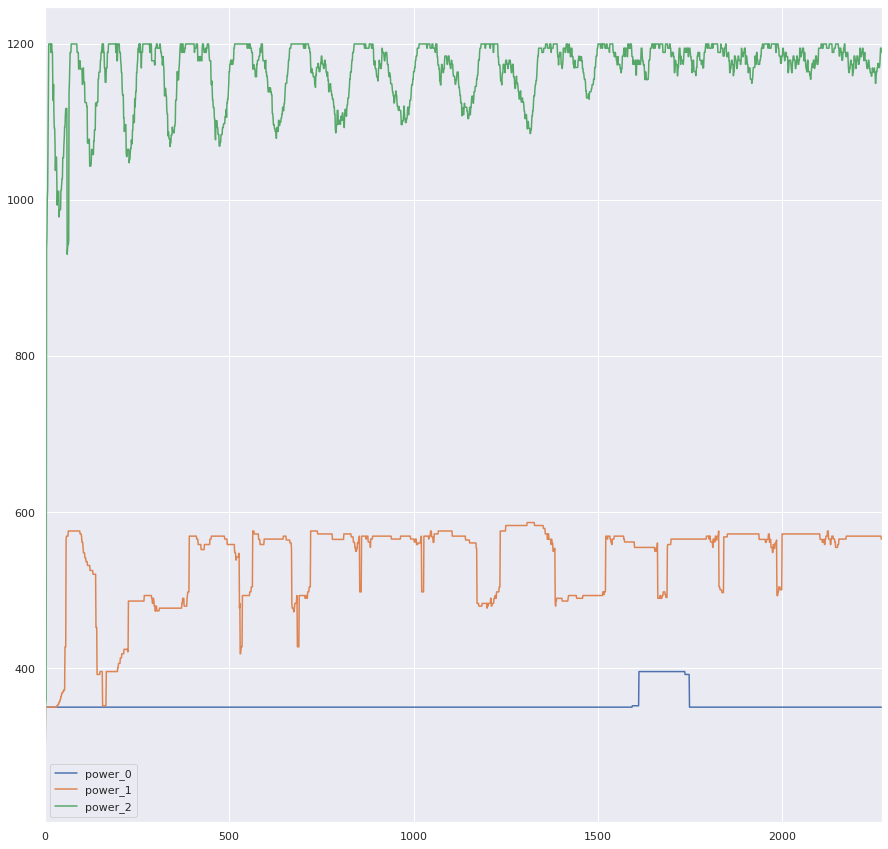

In [56]:
scaled_df.plot(y=["power_0","power_1","power_2"], figsize=(15,15))

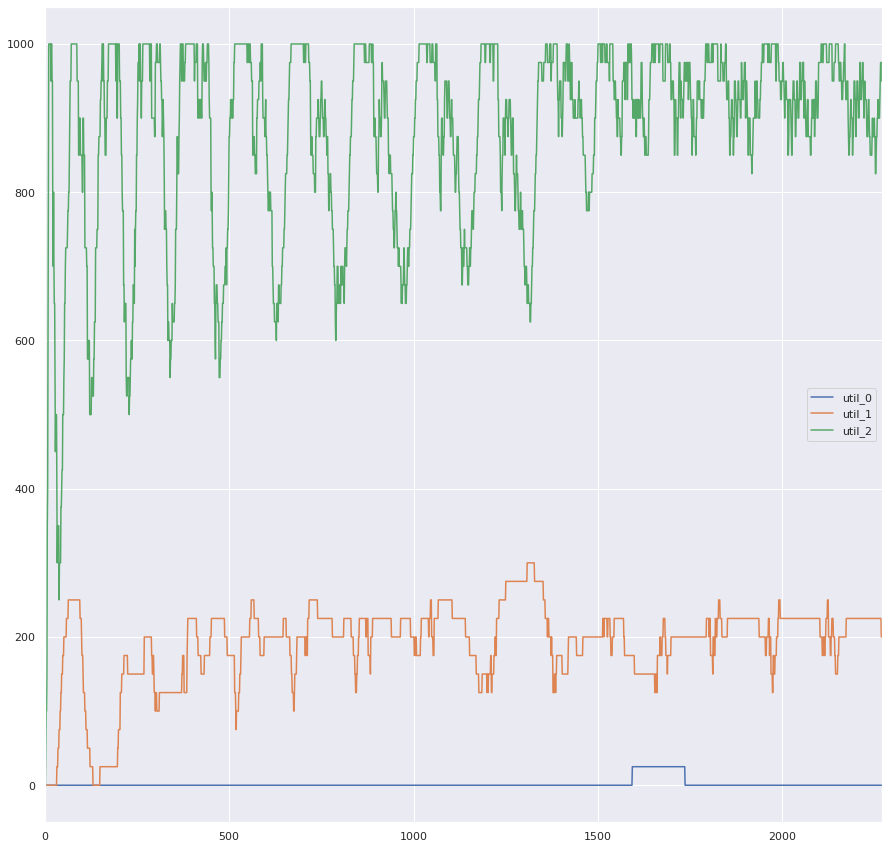

In [57]:
scaled_df.plot(y=["util_0","util_1","util_2"], figsize=(15,15))


# REWARD, Q-VALUES, ETC. INFO

In [273]:
!ls ../info/

dist.txt	     q_vals.txt        vanilla_a3c_training_info.txt
mercury_info_parsed  train_arrays.txt  vanilla_a3c_training_results.csv


In [21]:
df_2 = pd.read_csv('../info/train_arrays.txt',
                   delimiter=",",
                   names=["log_prob", "_", "reward", "v_vals",
                          "q_vals", "entropy"])
df_2 = df_2.drop(["_"], axis=1)
df_2["log_prob"] = df_2["log_prob"].apply(lambda x: x.split("(")[1])
df_2["log_prob"] = df_2["log_prob"].astype("float64")



df_2["a_vals"] = df_2.q_vals - df_2.v_vals

df_2

,log_prob,reward,v_vals,q_vals,entropy,a_vals
0,-0.9397,-1712.977295,-0.585310,3.254298,1.085074,3.839608
1,-1.0576,-1781.469727,-0.534904,3.198241,1.088802,3.733145
2,-1.3049,-1857.615234,-0.524900,3.156299,1.088897,3.681199
3,-0.9785,-1900.407227,-0.520797,3.130255,1.090575,3.651052
4,-0.9630,-1900.407227,-0.556411,3.113120,1.089441,3.669531
...,...,...,...,...,...,...
955035,-0.0253,-2108.898682,-1.158937,0.064677,0.131551,1.223615
955036,-0.0253,-2108.898682,-1.158937,0.078641,0.131551,1.237579
955037,-0.0243,-2115.871094,-1.172355,0.092746,0.127150,1.265102
955038,-0.0243,-2115.871094,-1.172355,0.108593,0.127150,1.280948


In [22]:
"""GAMMA = 0.99
rew = df_2.reward.values
rew = (rew - np.mean(rew)) / (np.std(rew) + 0.00000000000000000001)
q_val = rew[-1]
q_vals = np.zeros_like(rew)

for i in reversed(range(len(rew))):
    q_val_temp = q_val
    q_val = rew[i] + GAMMA * q_val
    q_vals[i] = q_val
q_vals = (q_vals - np.mean(q_vals)) / (np.std(q_vals) + EPSILON)

plt.figure(figsize=(10,10))
plt.plot(q_vals)
plt.show()"""
print()

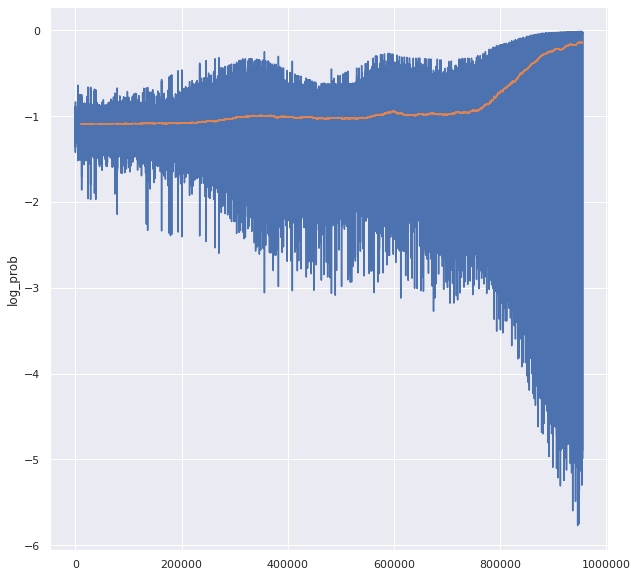

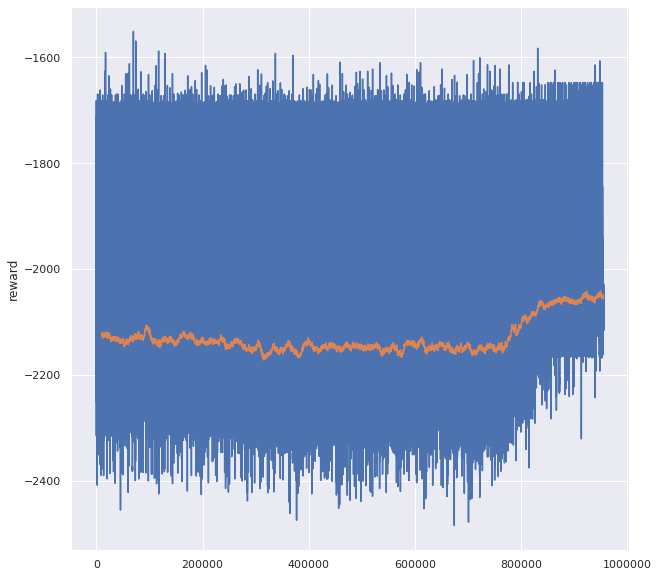

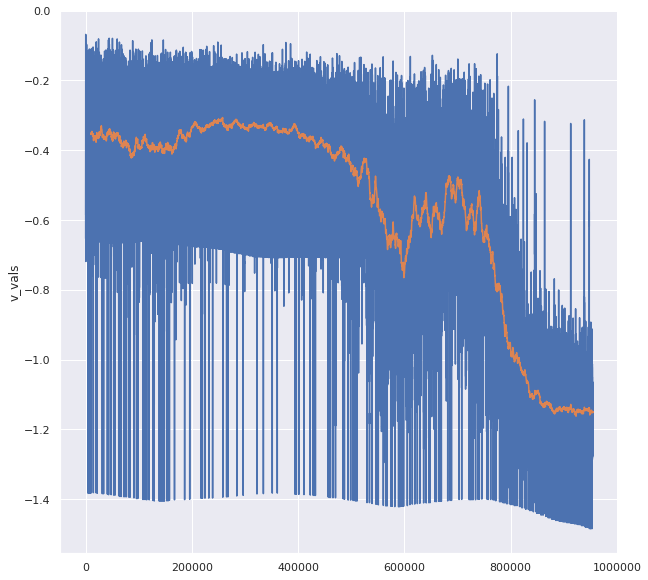

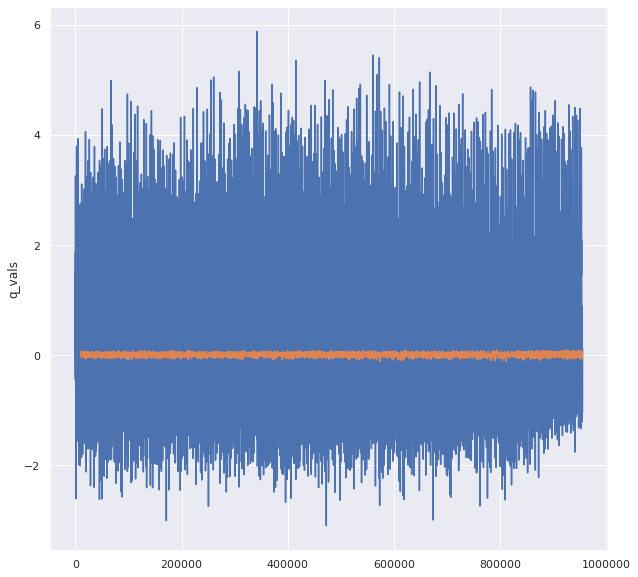

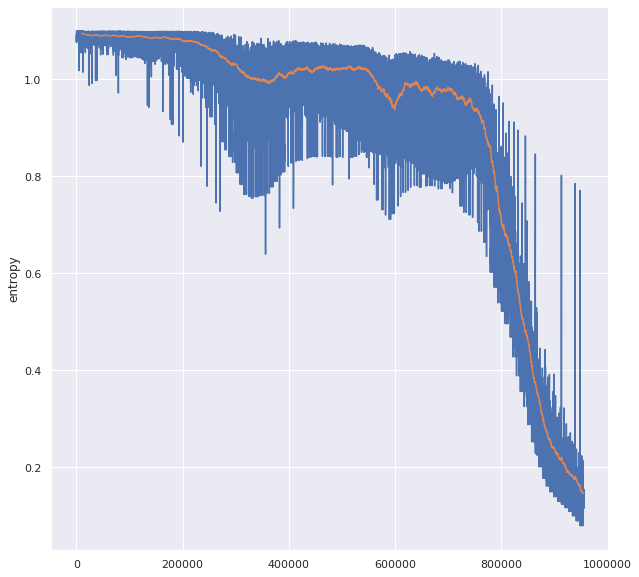

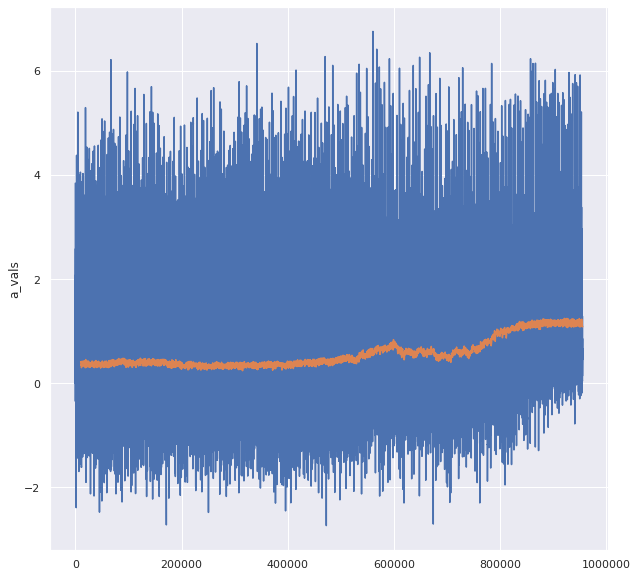

In [28]:
for col in df_2.columns:
    plt.figure(figsize=(10,10))
    plt.plot(df_2[col])
    plt.plot(pd.Series.rolling(pd.Series(df_2[col]), 10000).mean())
    plt.ylabel(col)
    plt.show()

# DISTRIBUTION INFO

In [64]:
df_3 = pd.read_csv('../info/dist.txt', delimiter=",", names=["dist"])
df_3["edc_0"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[0][1:])
df_3["edc_1"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[1])
df_3["edc_2"] = df_3.dist.apply(lambda x: list(filter(lambda a: a is not "", x.split(" ")))[2][:-1])

df_3.edc_0 = df_3.edc_0.astype("float64")
df_3.edc_1 = df_3.edc_1.astype("float64")
df_3.edc_2 = df_3.edc_2.astype("float64")

df_3 = df_3.drop(["dist"], axis=1)

df_3

,edc_0,edc_1,edc_2
0,0.401137,0.252545,0.346319
1,0.396107,0.267196,0.336696
2,0.391876,0.270673,0.337451
3,0.376978,0.277147,0.345876
4,0.358434,0.281110,0.360457
...,...,...,...
858152,0.389402,0.280210,0.330388
858153,0.389402,0.280210,0.330388
858154,0.379362,0.288778,0.331860
858155,0.389402,0.280210,0.330388


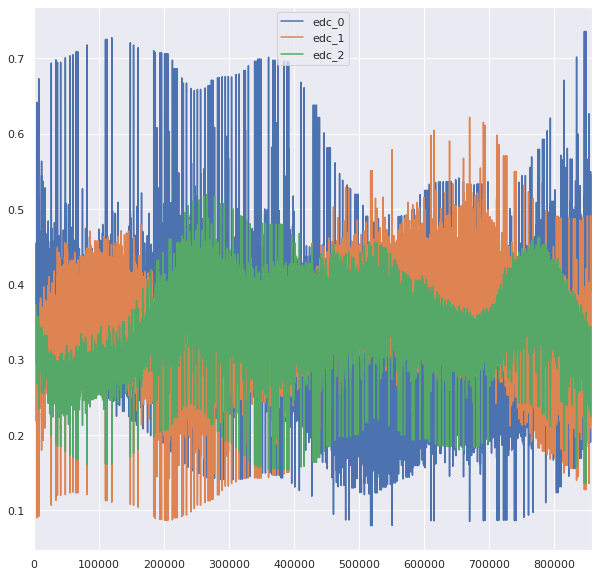

In [65]:
df_3.plot(y=["edc_0","edc_1","edc_2"], figsize=(10,10))

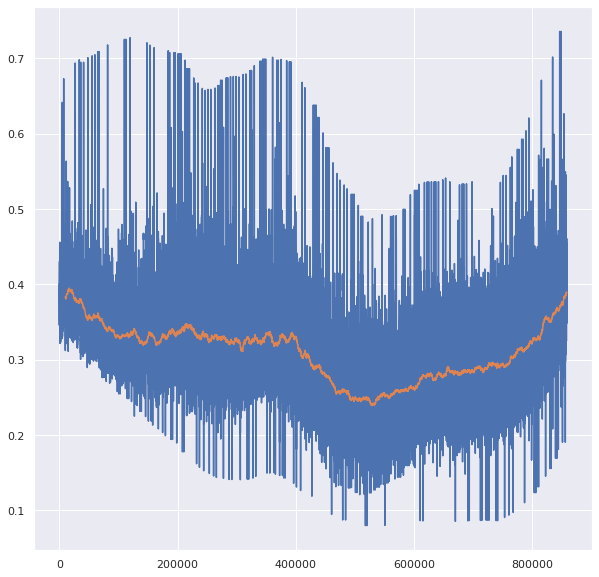

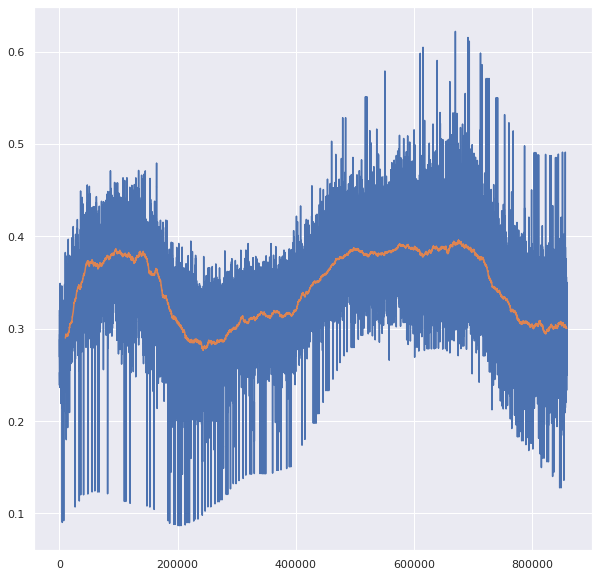

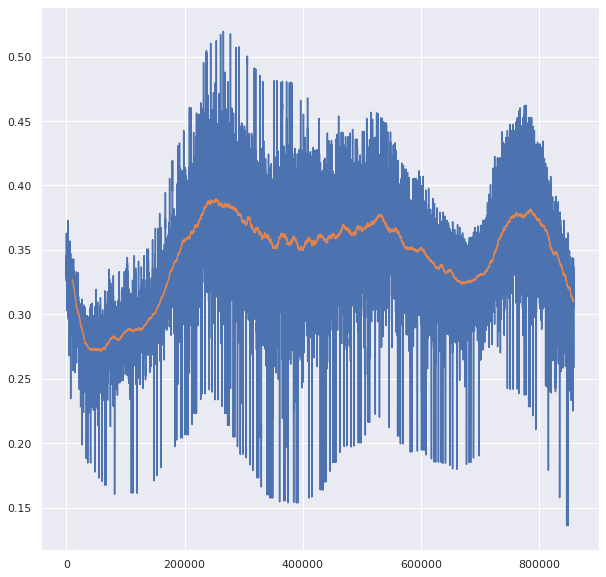

In [66]:
for col in df_3.columns:
    plt.figure(figsize=(10,10))
    plt.plot(df_3[col])
    plt.plot(pd.Series.rolling(pd.Series(df_3[col]), 10000).mean())
plt.show()


# REWARD COMPUTATION

In [61]:
"""  
### OPTION 1 ### no scale

if penalty[i]:
    reward = -AVAILABILITY_PENALTY
else:
    power_consumption = x[i+1, 1::2]
    reward = -np.sum(np.power(power_consumption, 3))

### OPTION 2 ### scale  

if penalty[i]:
    reward = -AVAILABILITY_PENALTY
else:
    utilization = x[i+1, 0::2]
    power_consumption = x[i+1, 1::2]
    reward = -np.sum(np.power(power_consumption/(utilization+1), 1))
if reward<-AVAILABILITY_PENALTY:
    reward = -AVAILABILITY_PENALTY

### OPTION 3 ### no scale, penalty = 0.5
wrong for positive numbers, although it always gives negative number with standard
not intended scaling for (-1,1) range using pow 3 -> not relevant for rewards around 50-100 but still "wrong"

power_consumption = x[i+1, 1::2]
total_power = np.sum(np.power(power_consumption, 3))
pen = penalty[i]
reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power

### OPTION 4 ### scale, penalty= 1,10,20

offset = np.sum(np.mean(x[:, 1::2], axis=0))/x[:, 1::2].shape[1]

power_consumption = x[i+1, 1::2] - offset
total_power = np.power(np.sum(power_consumption), 1)
pen = penalty[i]
if total_power > 0:
    reward = - (1 + AVAILABILITY_PENALTY * pen) * total_power
else:
    reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power
"""
print()

907.3789839933485


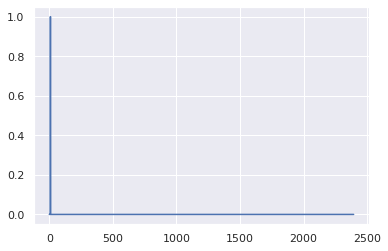

(2394, 6)
908.4810071321893


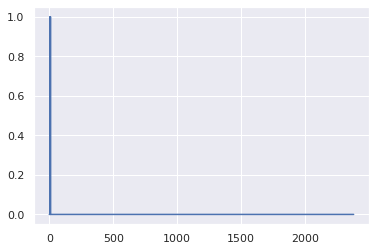

(2381, 6)
904.6188813894291


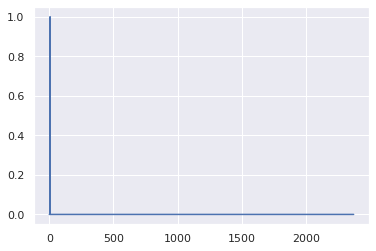

(2374, 6)
3 2380


In [62]:
EPSILON = np.finfo(np.float32).eps
AVAILABILITY_PENALTY = 0

rewards = []
#directory = "../results/vanilla_a3c_v2_lite_env_6_UE_50_GPUperEDC_10_standarize_data&Qvalues_reward_sumrealPOP1P2adam_1e3_ep_30_penalty_1_neurons_128/a3c/"
directory = "../data/a3c/"



for filename in sorted(os.listdir(directory)):
    
    tmp_cols = ["util_0", "power_0",
                "util_1", "power_1",
                "util_2", "power_2",
                "action", "penalty"]
    
    df_tmp = pd.read_csv(os.path.join(directory, filename), delimiter=";", names=tmp_cols).iloc[6:]
    
    
    x = df_tmp[["util_0", "power_0",
                "util_1", "power_1",
                "util_2", "power_2"]].values
    penalty = df_tmp["penalty"].values
    
    
    scale_pair = scale_dict[scale_mode][scale_factor]["util"]
    x[:,0::2] = inverse_scale_data(x[:, 0::2])

    scale_pair = scale_dict[scale_mode][scale_factor]["power"]
    x[:,1::2] = inverse_scale_data(x[:, 1::2])
    
    """
    offset = inverse_scale_data(offset)
    """

    offset = np.sum(np.mean(x[:, 1::2], axis=0))/x[:, 1::2].shape[1]
    print(offset)

    
    plt.plot(penalty)
    plt.show()
    
    
    ep_rewards = []
    print(x.shape)
    
    for i in range(len(x)-1):
        
        power_consumption = x[i+1, 1::2] # - offset
        total_power = np.power(np.sum(power_consumption), 1)
        pen = penalty[i]
        if total_power > 0:
            reward = - (1 + AVAILABILITY_PENALTY * pen) * total_power
        else:
            reward = - (1 - AVAILABILITY_PENALTY * pen) * total_power
        
        ep_rewards.append(reward)
    rewards.append(ep_rewards)

print(len(rewards), len(rewards[1]))

mean reward 0: -2722.2072896979485
mean reward 1: -2725.515132416874
mean reward 2: -2713.924085319189


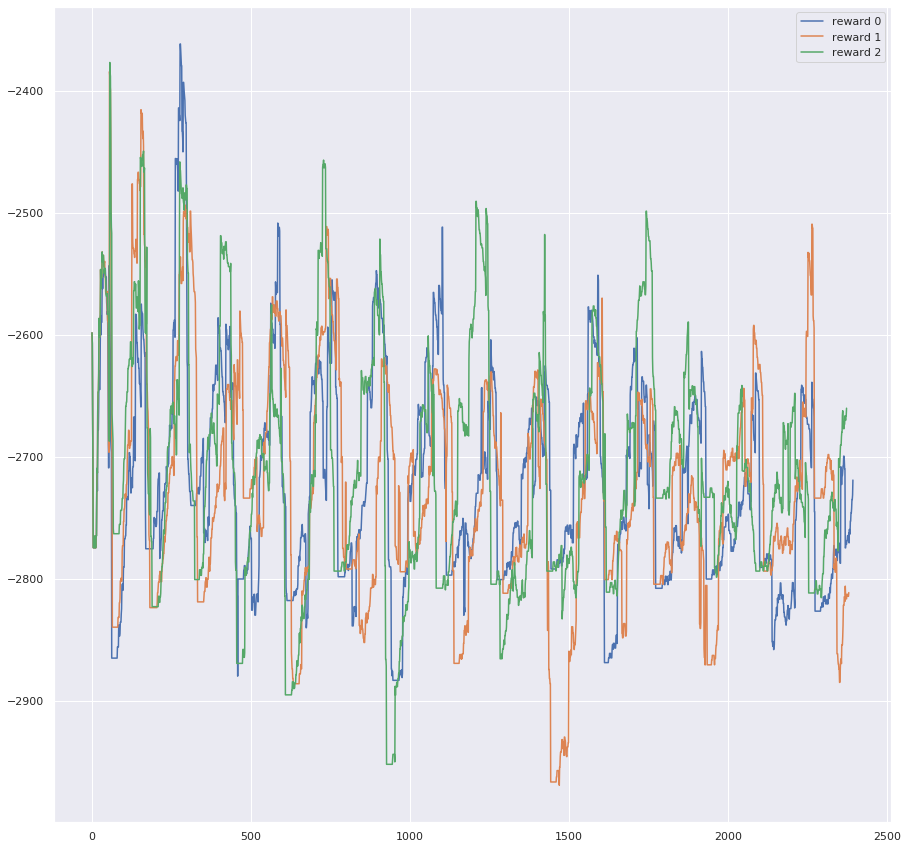

In [63]:
plt.figure(figsize=(15,15))
for i in range(len(rewards)):
    print("mean reward {}: {}".format(i, sum(rewards[i])/len(rewards[i])))
    plt.plot(rewards[i][:])
plt.legend(["reward "+str(i) for i in range(len(rewards))])
plt.show()

# Episodes: Loss, Mean Reward, etc.

In [217]:
! ls ../info

dist.txt	     q_vals.txt        vanilla_a3c_training_info.txt
mercury_info_parsed  train_arrays.txt  vanilla_a3c_training_results.csv


In [58]:
df_4 = pd.read_csv('../info/vanilla_a3c_training_results.csv',
                   delimiter=";",
                   names=["episodes", "length", "rewards", "loss", "entropies"])
df_4

,episodes,length,rewards,loss,entropies
0,0,7193,-1.961843e+07,-0.014354,-0.001089
1,1,7228,-1.963521e+07,-0.040366,-0.001086
2,2,7210,-1.959971e+07,-0.040122,-0.001089
3,3,7178,-1.958948e+07,-0.012450,-0.001087
4,4,7141,-1.940026e+07,0.008628,-0.001086
...,...,...,...,...,...
115,55,7206,-1.951794e+07,0.019371,-0.001089
116,56,7171,-1.952482e+07,-0.011813,-0.001088
117,57,7195,-1.946870e+07,0.002941,-0.001090
118,58,7010,-1.900567e+07,-0.013035,-0.001087


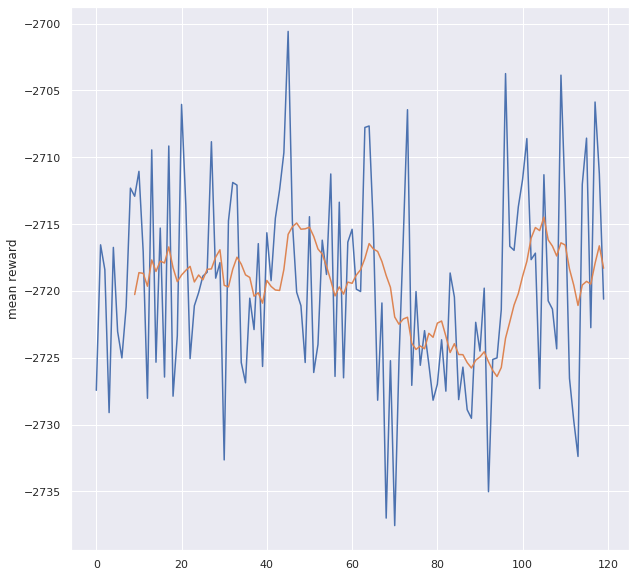

In [59]:
plt.figure(figsize=(10,10))
plt.plot(df_4["rewards"]/df_4["length"])
plt.plot(pd.Series.rolling(pd.Series(df_4["rewards"]/df_4["length"]), 10).mean())
plt.ylabel("mean reward")
plt.show()

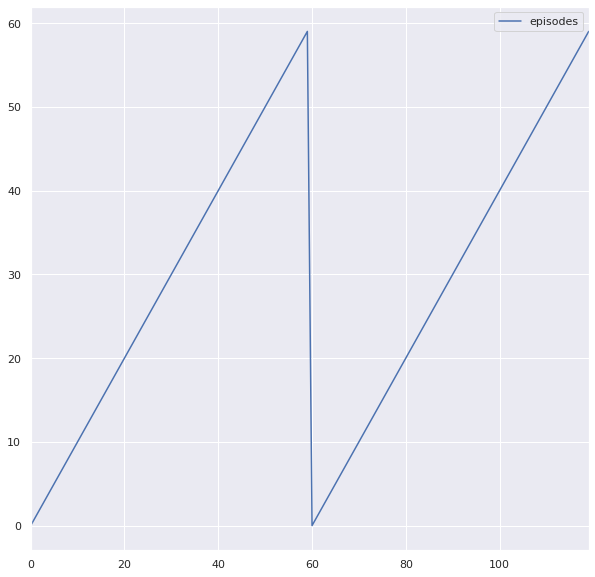

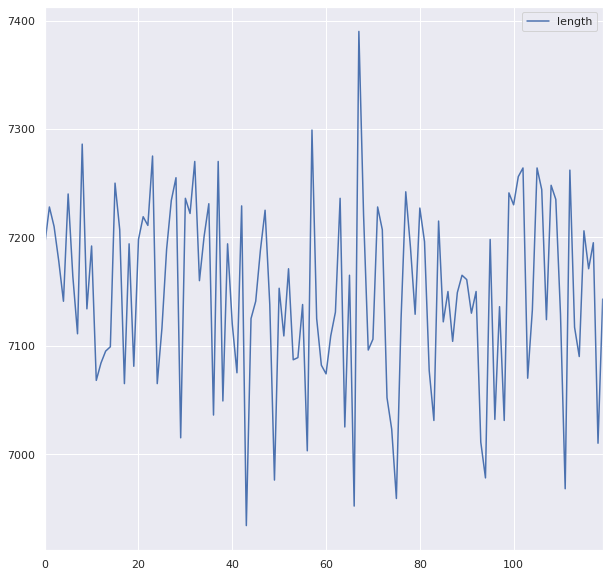

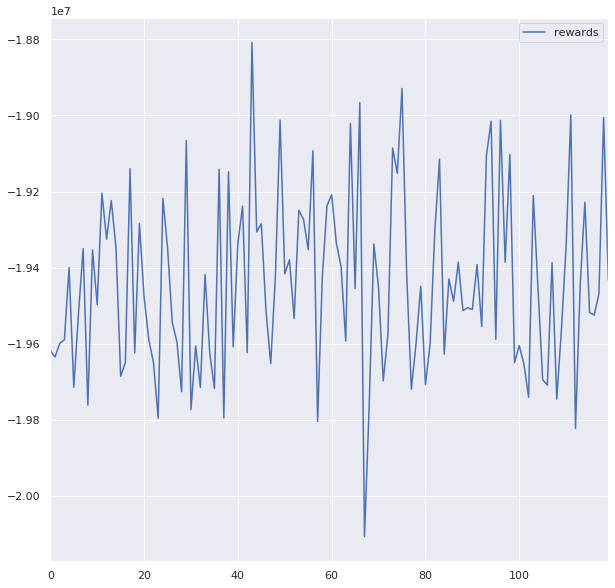

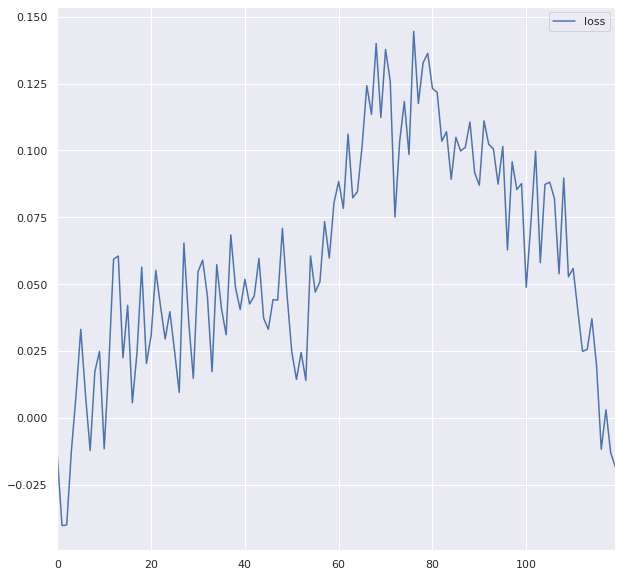

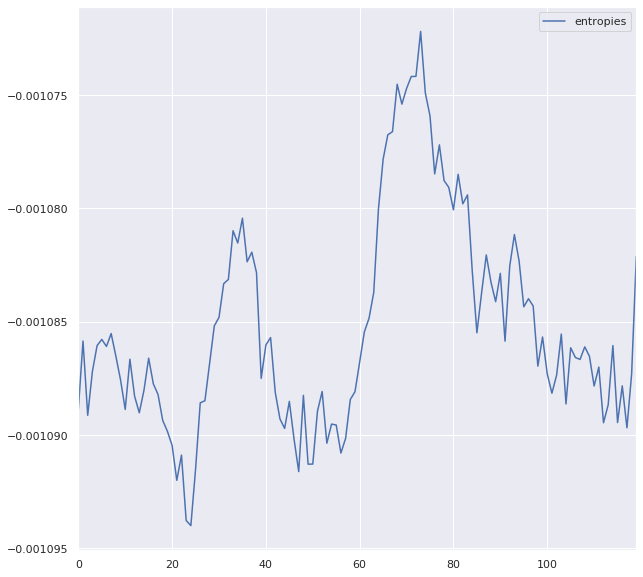

In [60]:
for col in df_4.columns:
    df_4.plot(y=col, figsize=(10,10))

# Episodes (2nd Option)

### Training info file must be cleaned before!! (remove lines with no commas)

In [96]:
df_5 = pd.read_csv('../info/vanilla_a3c_training_info.txt',
                   delimiter=",",
                   names=["episodes", "time", "length", "mean rewards", "loss"])

def compute_loss(x):
    losses = x.split(":")[1].split(" ")
    return sum([float(l) for l in losses[1:]])

for col in df_5.columns[:-1]:
    df_5[col] = df_5[col].str.split(":").str[1].astype(np.float)
df_5["entropy"] =  df_5["loss"].str.split(":").str[1].str.split(" ").str[3].astype(np.float)
df_5["loss"] =  df_5["loss"].apply(compute_loss)
df_5

AttributeError: 'float' object has no attribute 'split'

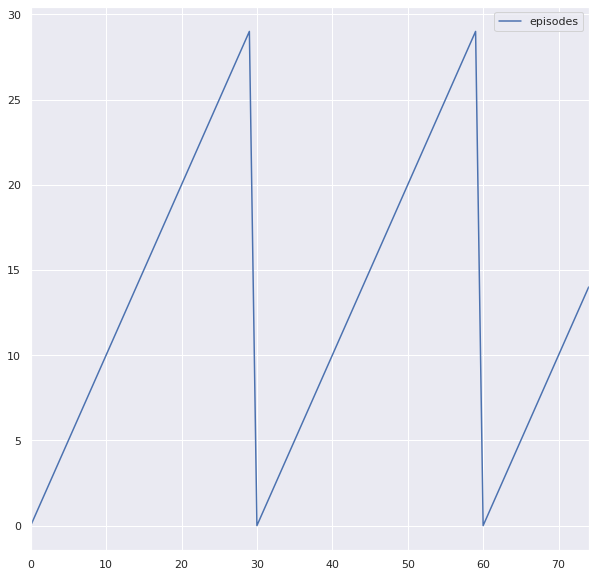

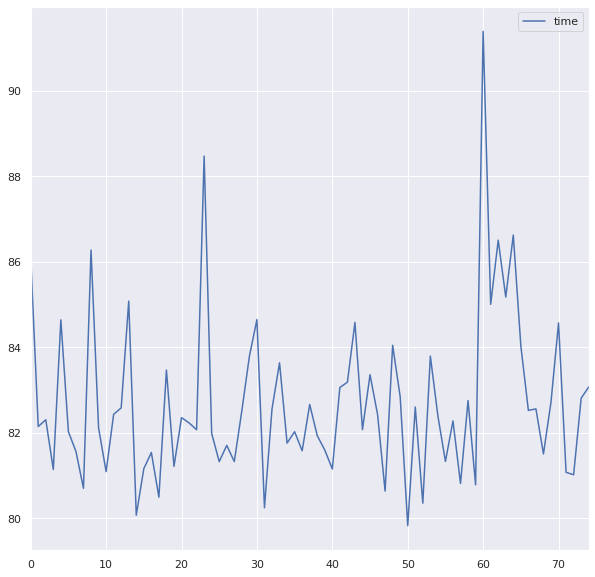

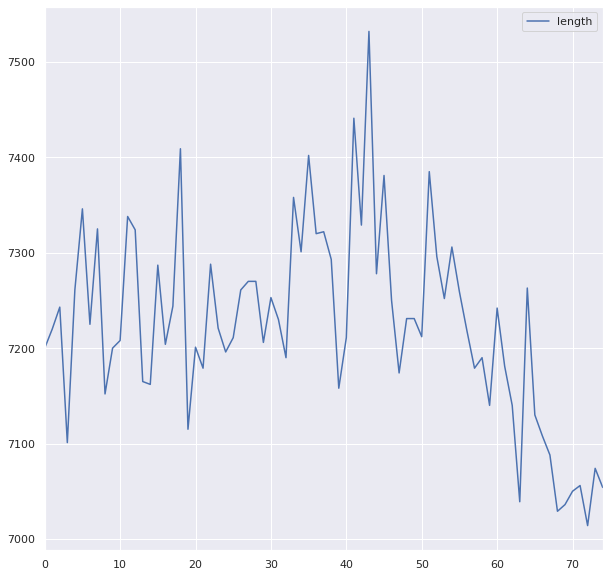

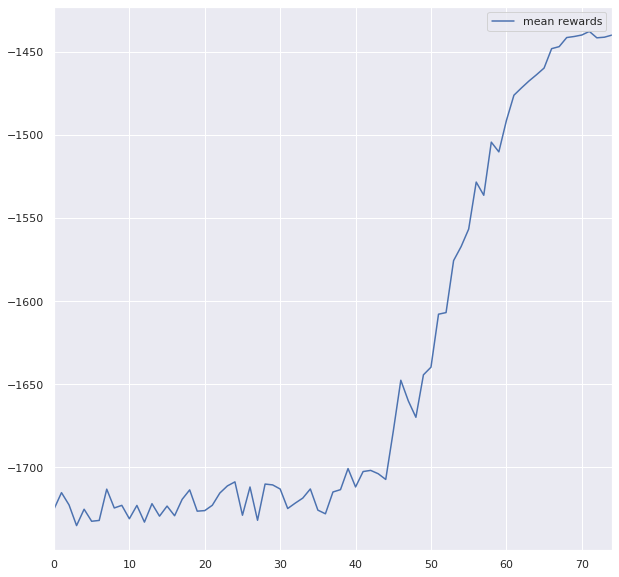

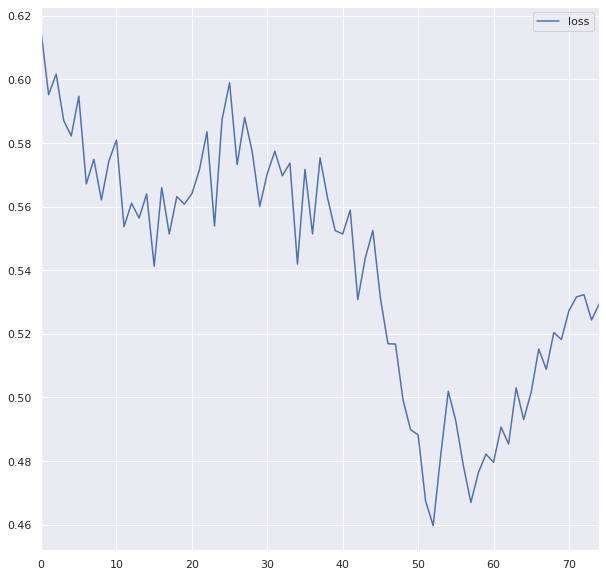

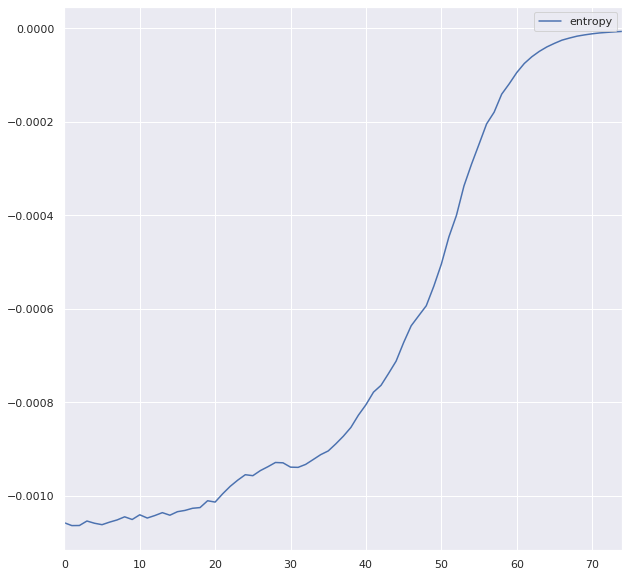

In [77]:
for col in df_5.columns:
    df_5.plot(y=col, figsize=(10,10))

# Extra

In [347]:
xxxx

array([-1000.,  -999.,  -998., ...,   998.,   999.,  1000.])

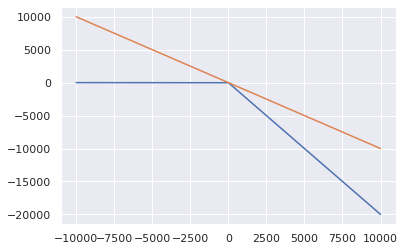

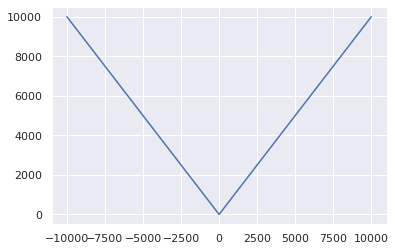

In [550]:
xxxx = np.linspace(-10000,10000, num=20001)
yyyy = []
AVAILABILITY_PENALTY = 1
for xxx in xxxx:
    if xxx > 0:
        yyy = - (1 + AVAILABILITY_PENALTY) * xxx
    else:
        yyy = - (1 - AVAILABILITY_PENALTY) * xxx
            
    yyyy.append(yyy)

plt.plot(xxxx, yyyy)
plt.plot(xxxx, -xxxx)
plt.show()
plt.plot(xxxx, -xxxx-yyyy)
plt.show()
